In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

In [120]:
df = pd.read_csv('call.csv')
df = df.iloc[:,1:]
df = df.rename({'maturity (in days)': 'T'}, axis = 1)
df.tail(10)

,T,strike,bid,ask,r,q,Forward Price
35,184,1375,82.2,84.5,0.743682,2.098077,1399.140991
36,184,1400,66.6,68.8,0.743682,2.098077,1399.146729
37,184,1425,52.5,54.5,0.743682,2.098077,1399.001953
38,184,1450,40.1,41.9,0.743682,2.098077,1399.859985
39,184,1475,29.5,31.0,0.743682,2.098077,1399.714966
40,269,1375,95.5,98.5,0.883147,2.154654,1393.822876
41,269,1400,80.4,83.4,0.883147,2.154654,1393.306274
42,269,1425,66.5,69.1,0.883147,2.154654,1393.594482
43,269,1450,53.7,56.4,0.883147,2.154654,1393.631104
44,269,1475,42.4,44.8,0.883147,2.154654,1393.516724


# Part one

## Free arbitrage restriction

In [5]:
t = df['T'].unique()

# Monotonicity
for time in t:
    new_df = df[df['T'] == time]
    ask = new_df['ask'].shift()[1:]
    bid = new_df['bid'][1:]
    for i in range(len(ask)):
        if ask.iloc[i] <= bid.iloc[i]:
            print("Based on the rule of monotonicity, there is immediate arbitrage opportunity!")

# Slope
for time in t:
    new_df = df[df['T'] == time]
    difference = new_df['bid'].shift() - new_df['ask']
    strike_diff = (new_df['strike'] - new_df['strike'].shift()) * np.exp(-new_df['r'] * new_df['T']/360)
    diff = difference[:] - strike_diff[:]
    for i in diff[1:]:
        if i >= 0:
            print("Based on the rule of Slope, there is immediate arbitrage opportunity!")

# Part two

Simulation of VGSA process

Try: 
* $\sigma$ = 0.2
* $\nu$ = 0.1
* $\theta$ = -0.4
* $\kappa$ = 2
* $\lambda$ = 1
* $\eta$ = 4.5


In [159]:
def gamma(u):
    return np.sqrt(k ** 2 - 2 * lam ** 2 * 1j * u)

def A(t, u):
    return np.exp(k**2 * eta * t / (lam ** 2))/ (np.cosh(gamma(u) * t / 2) + k/gamma(u) * np.sinh(gamma(u)*t/2)) ** (2 * k * eta / (lam ** 2))

def B(t, u):
    return (2 * 1j * u) / (k + gamma(u) * np.cosh(gamma(u) * t / 2) / np.sinh(gamma(u) * t / 2))

def characteristic_function_cir(u, t, y0, k, eta, lam):
    return A(t, u) * np.exp(B(t, u) * y0)

def characteristic_function_vg(u):
    return -1/nu * np.log(1 - 1j * u * theta * nu + sigma**2 * nu * u**2 / 2)


In [228]:
sigma = 0.2
nu = 0.1
theta = -0.4
k = 2
lam = 1
eta = 4.5

N = 50
num_paths = 10000
data = df.iloc[1,:]
T = 2
T = T / 360
dt = T / N
t = np.arange(0, T+dt/2, dt)
x = np.zeros_like(t)
y = np.zeros_like(t)
s = np.zeros_like(t)


x_f = data['Forward Price']
r = data['r']
q = data['q']
s0 = x_f * np.exp(-(r-q) * T)

s[0] = np.log(s0)
x[0] = 0
y[0] = 0.03

s_paths = np.zeros((num_paths, len(s)))
for num in range(num_paths):
    for i in range(N):
        z = np.random.randn()
        y[i+1] = y[i] + k * (eta - y[i]) * dt + lam * np.sqrt(y[i]) * np.sqrt(dt) * z + lam**2 / 4 * dt * (z**2 - 1)
        t_hat = dt/2 * (y[i] + y[i+1])
        g = np.random.gamma(t_hat/ nu, nu)
        z = np.random.randn()
        x[i+1] = theta * g + sigma * sigma * np.sqrt(g) * z
        
    for i in range(2, N+1):
        first = np.log(characteristic_function_cir(-1j*characteristic_function_vg(-1j), (i-1) * dt, 1/nu, k, eta, lam))
        second = np.log(characteristic_function_cir(-1j*characteristic_function_vg(-1j), (i) * dt, 1/nu, k, eta, lam))
        w = first - second
        s[i-1] = s[i-2] + (r-q) * dt + w + x[i-1]
    s_paths[num] = s

/var/folders/qn/03t76jqd1t31l24v1ryyyxkr0000gn/T/ipykernel_13361/3426121314.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  s[i-1] = s[i-2] + (r-q) * dt + w + x[i-1]


(10000, 51)

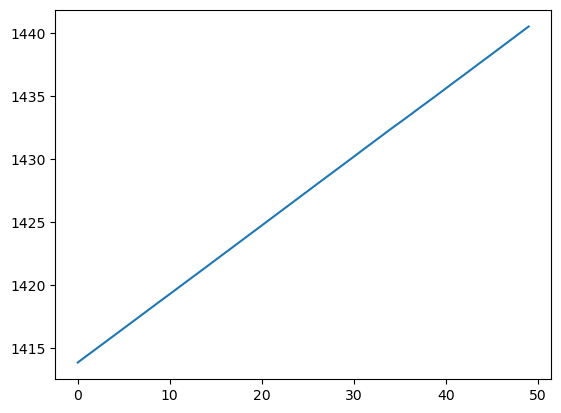